In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna 
import pandas as pd
from tensorflow.keras.optimizers import SGD
import matplotlib.dates as mdates

In [3]:
dataset = yf.Ticker("IBM")

from_date = "2020-01-01"
end_date = "2025-04-01"


dataset = dataset.history(start=from_date, end=end_date)
Dataprediksi = dataset.copy()
dataset.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,101.602760,102.295168,101.429663,101.918861,3293436,0.0,0.0
2020-01-03 00:00:00-05:00,100.526516,101.497392,100.518990,101.106033,2482890,0.0,0.0
2020-01-06 00:00:00-05:00,100.413619,101.030759,100.248042,100.925400,2537073,0.0,0.0
2020-01-07 00:00:00-05:00,100.616833,101.572651,100.398576,100.993134,3232977,0.0,0.0
2020-01-08 00:00:00-05:00,101.233994,102.250024,100.789950,101.836082,4545916,0.0,0.0


In [4]:
DS = dataset.drop(columns=['Dividends', 'Stock Splits'])
DS.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,101.602760,102.295168,101.429663,101.918861,3293436
2020-01-03 00:00:00-05:00,100.526516,101.497392,100.518990,101.106033,2482890
2020-01-06 00:00:00-05:00,100.413619,101.030759,100.248042,100.925400,2537073
2020-01-07 00:00:00-05:00,100.616833,101.572651,100.398576,100.993134,3232977
2020-01-08 00:00:00-05:00,101.233994,102.250024,100.789950,101.836082,4545916


In [5]:
DS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1318 entries, 2020-01-02 00:00:00-05:00 to 2025-03-31 00:00:00-04:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1318 non-null   float64
 1   High    1318 non-null   float64
 2   Low     1318 non-null   float64
 3   Close   1318 non-null   float64
 4   Volume  1318 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 61.8 KB


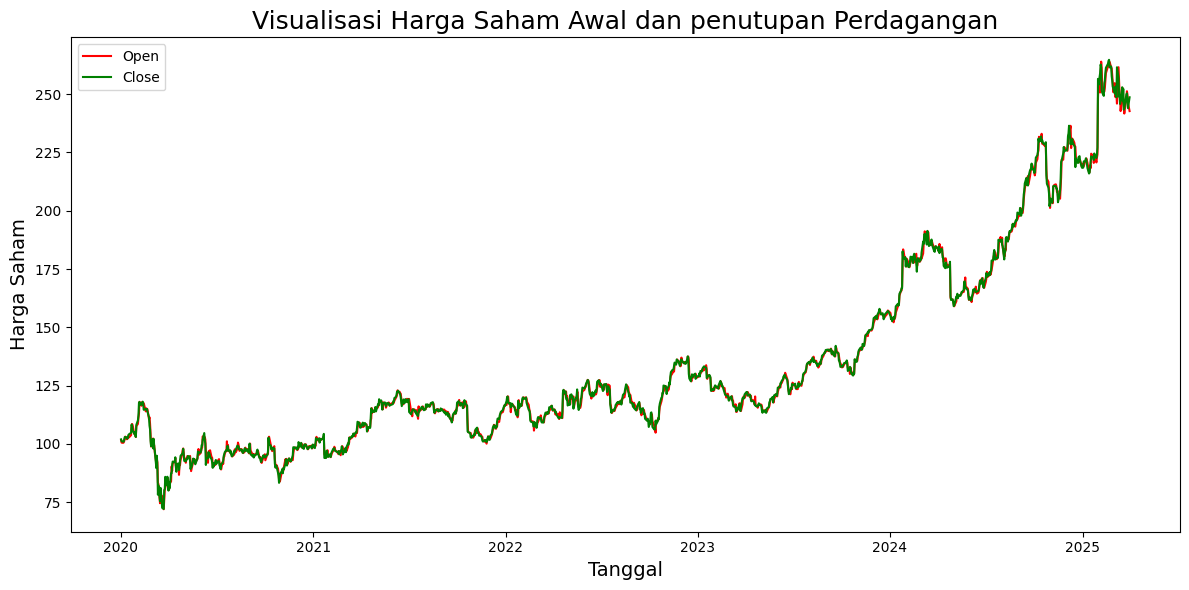

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Open', data=DS, label='Open', color='r')
sns.lineplot(x='Date', y='Close', data=DS, label='Close', color='g')

plt.title('Visualisasi Harga Saham Awal dan penutupan Perdagangan', fontsize = 18)
plt.xlabel('Tanggal', fontsize = 14)
plt.ylabel('Harga Saham', fontsize = 14)
plt.tight_layout()
plt.legend()
plt.show()


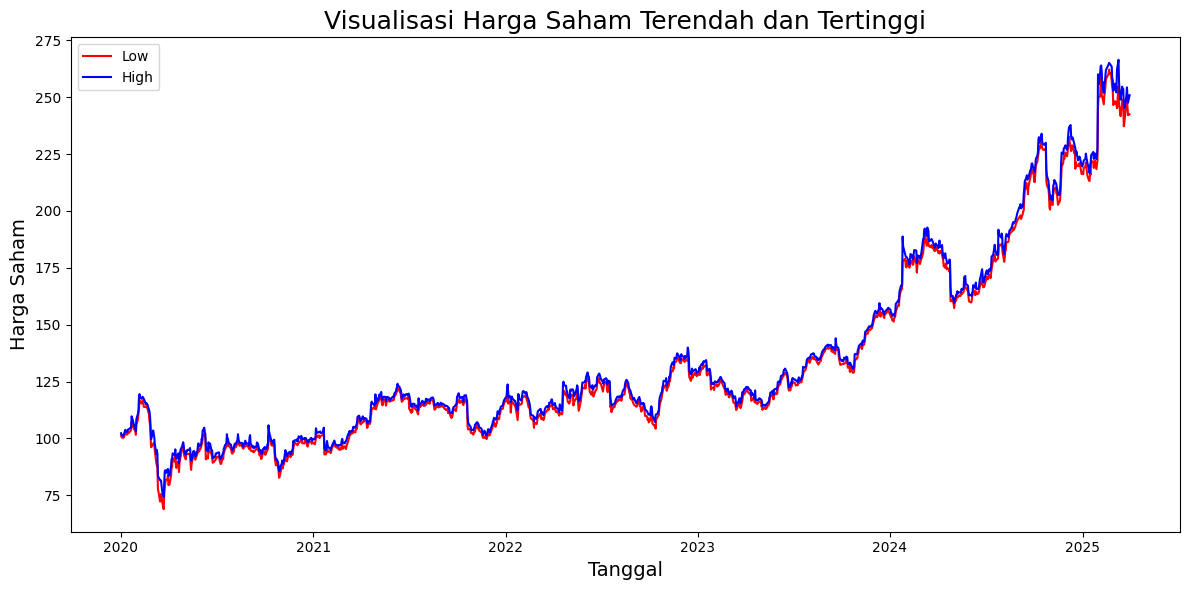

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Low', data=DS, label='Low', color='r')
sns.lineplot(x='Date', y='High', data=DS, label='High', color='b')

plt.title('Visualisasi Harga Saham Terendah dan Tertinggi', fontsize = 18)
plt.xlabel('Tanggal', fontsize = 14)
plt.ylabel('Harga Saham', fontsize = 14)
plt.tight_layout()
plt.legend()
plt.show()

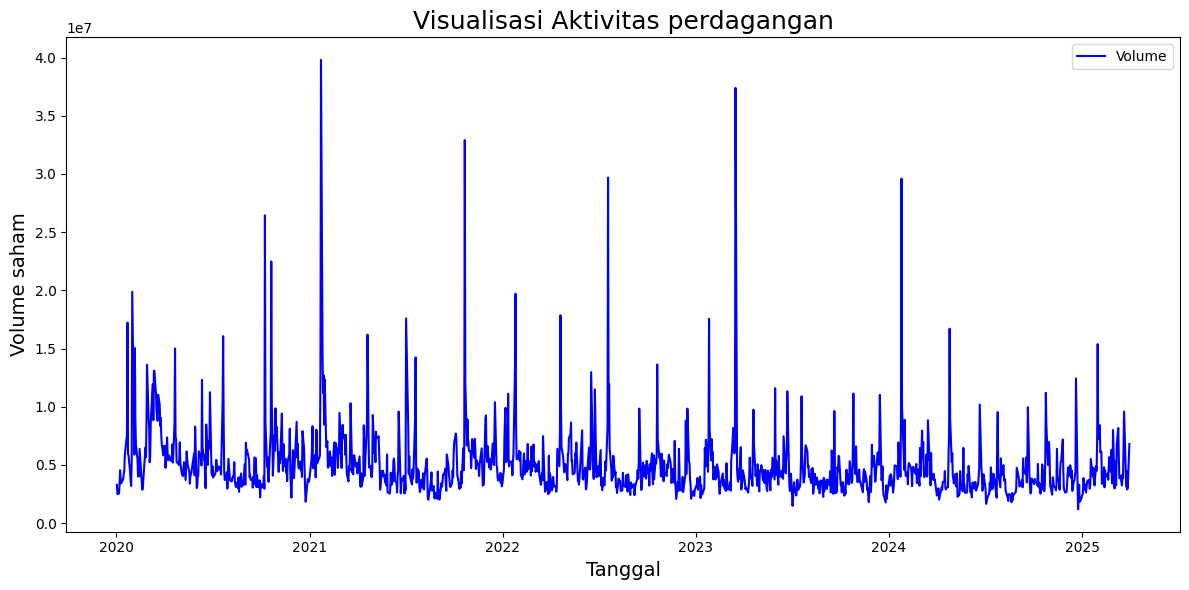

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Volume', data=DS, label='Volume', color='b')

plt.title('Visualisasi Aktivitas perdagangan', fontsize = 18)
plt.xlabel('Tanggal', fontsize = 14)
plt.ylabel('Volume saham', fontsize = 14)
plt.tight_layout()
plt.legend()
plt.show()

In [6]:
close_prices = DS[['Close']].values
train_size   = int(len(close_prices) * 0.8)
train_raw    = close_prices[:train_size]
test_raw     = close_prices[train_size:]

In [8]:
def objective(trial):
    max_window = len(train_raw) - 1
    window_size = trial.suggest_int("window_size", 1, max_window)

    scaler = MinMaxScaler()
    scaler.fit(train_raw)
    train_scaled = scaler.transform(train_raw)
    seed        = train_scaled[-window_size:]
    test_scaled = scaler.transform(test_raw)
    combined    = np.vstack([seed, test_scaled])

    def create_seq(data, w):
        X, y = [], []
        for i in range(w, len(data)):
            X.append(data[i-w:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_seq(train_scaled, window_size)
    X_val,   y_val   = create_seq(combined,    window_size)

    X_train = X_train.reshape(-1, window_size, 1)
    X_val   = X_val.reshape(-1, window_size, 1)

    sgd_opt = SGD(
    learning_rate=0.01,   
    momentum=0.9,         
    nesterov=True         
    )

    model = Sequential([
        Input(shape=(window_size, 1)),
        #LSTM(128),
        #LSTM(64),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=sgd_opt, loss="mse")

    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=10,
              batch_size=32,
              verbose=0)

    preds = model.predict(X_val)
    rmse  = np.sqrt(mean_squared_error(y_val, preds))
    return rmse


In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best window_size:", study.best_params["window_size"])
print("Best RMSE:       ", study.best_value)

[I 2025-05-05 09:08:33,068] A new study created in memory with name: no-name-1ebcba51-2b98-4410-9067-f9c692d8f3bb


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2025-05-05 09:09:14,565] Trial 0 finished with value: 0.10694880015122854 and parameters: {'window_size': 457}. Best is trial 0 with value: 0.10694880015122854.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2025-05-05 09:09:44,516] Trial 1 finished with value: 0.07023966856837559 and parameters: {'window_size': 169}. Best is trial 1 with value: 0.07023966856837559.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2025-05-05 09:09:53,642] Trial 2 finished with value: 0.08664492599679381 and parameters: {'window_size': 6}. Best is trial 1 with value: 0.07023966856837559.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


[I 2025-05-05 09:10:23,131] Trial 3 finished with value: 0.15065544969926178 and parameters: {'window_size': 163}. Best is trial 1 with value: 0.07023966856837559.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


[I 2025-05-05 09:11:02,441] Trial 4 finished with value: 0.23019569021989547 and parameters: {'window_size': 791}. Best is trial 1 with value: 0.07023966856837559.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step


[I 2025-05-05 09:11:33,424] Trial 5 finished with value: 0.2806851185598437 and parameters: {'window_size': 818}. Best is trial 1 with value: 0.07023966856837559.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


[I 2025-05-05 09:12:17,394] Trial 6 finished with value: 0.17976918185891275 and parameters: {'window_size': 732}. Best is trial 1 with value: 0.07023966856837559.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-05-05 09:12:50,457] Trial 7 finished with value: 0.10011121767893212 and parameters: {'window_size': 402}. Best is trial 1 with value: 0.07023966856837559.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[I 2025-05-05 09:13:33,391] Trial 8 finished with value: 0.22188264057175341 and parameters: {'window_size': 587}. Best is trial 1 with value: 0.07023966856837559.


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2025-05-05 09:14:00,845] Trial 9 finished with value: 0.07077832030290734 and parameters: {'window_size': 270}. Best is trial 1 with value: 0.07023966856837559.


Best window_size: 169
Best RMSE:        0.07023966856837559


In [10]:
best_window = study.best_params["window_size"]

scaler = MinMaxScaler()
scaler.fit(train_raw)
train_scaled = scaler.transform(train_raw)
test_scaled  = scaler.transform(test_raw)

seed       = train_scaled[-best_window:]
combined   = np.vstack([seed, test_scaled])

def create_seq(data, w):
    X, y = [], []
    for i in range(w, len(data)):
        X.append(data[i-w:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_seq(train_scaled, best_window)
X_test,  y_test  = create_seq(combined,    best_window)

X_train = X_train.reshape(-1, best_window, 1)
X_test  = X_test.reshape(-1, best_window, 1)


#X_full, X_val, y_full, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, random_state=15)

sgd_opt = SGD(
    learning_rate=0.015,   
    momentum=0.95,         
    nesterov=True         
)

model = Sequential([
    Input(shape=(best_window, 1)),
    #LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    #LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=sgd_opt, loss="mse")

history = model.fit(X_train, y_train,
          epochs=200,
          batch_size=32,
          #validation_data=(X_test, y_test), 
          verbose=1)

print("Keys in history:", history.history.keys())

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0435
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0081
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0029
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0021
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0020
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0017
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0019
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0017
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0014
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0017
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0017
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0014
Epoch 13/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0013
Epoch 14/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0014
Epoch 15/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [11]:
hasil_prediksi = model.predict(X_test)
prediksi = scaler.inverse_transform(hasil_prediksi)
uji_y_skala = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(uji_y_skala, prediksi)
mae = mean_absolute_error(uji_y_skala, prediksi)
rmse = np.sqrt(mse)
r2 = r2_score(uji_y_skala, prediksi)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2: {r2}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
Mean Squared Error: 34.62776824057357
Mean Absolute Error: 4.031431776104551
Root Mean Squared Error: 5.884536365812822
R^2: 0.9617043743720393


In [15]:
def predict_future(model, last_window, n_days, scaler):
    future = []
    window = last_window.copy()
    for _ in range(n_days):
        pred = model.predict(window.reshape(1, -1, 1), verbose=0)
        future.append(pred[0,0])
        window = np.append(window[1:], pred)
    return scaler.inverse_transform(np.array(future).reshape(-1,1))

last_seq = np.concatenate([train_scaled, test_scaled])[-best_window:]
pred120 = predict_future(model, last_seq, 120, scaler).flatten()
print(f"Prediksi saham 4 bulan kedepan: {pred120[-1]:.2f}")

Prediksi saham 4 bulan kedepan: 286.84


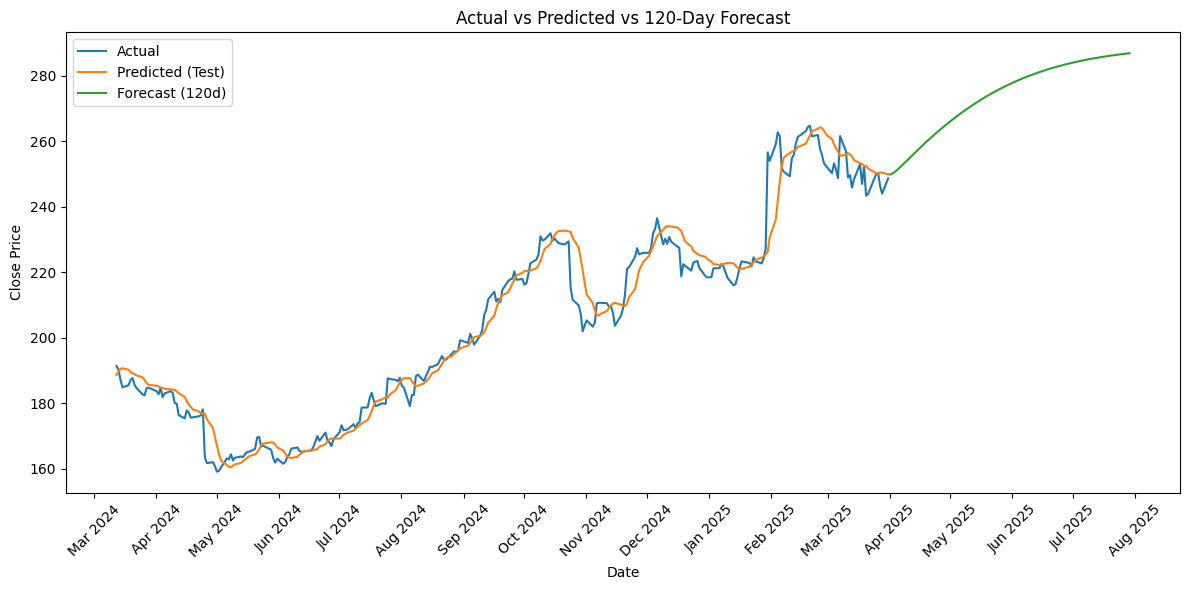

In [17]:
DS.index = pd.to_datetime(DS.index)
dates_test = DS.index[train_size:]
dates_future = pd.date_range(start=DS.index.max() + pd.Timedelta(days=1), periods=120, freq='D')

series_actual = pd.Series(uji_y_skala.flatten(), index=dates_test)
series_pred   = pd.Series(prediksi.flatten(), index=dates_test)
series_fut    = pd.Series(pred120, index=dates_future)

plt.figure(figsize=(12,6))
plt.plot(series_actual, label='Actual')
plt.plot(series_pred, label='Predicted (Test)')
plt.plot(series_fut, label='Forecast (120d)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.title('Actual vs Predicted vs 120-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()